# Import

In [1]:
data_path='data/'
api_key='ehlVSIKSMiugJZHlii3sU7OKCexe4MIlnYenGric'
import pandas as pd 
import numpy as np
from scipy import stats
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Analysis

## Take  a look on dataset

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_csv(f"{data_path}epi_r.csv")
for name, count in df.nunique().items():
    print(f"{name}: {count}")

title: 17736
rating: 8
calories: 1858
protein: 282
fat: 326
sodium: 2434
#cakeweek: 2
#wasteless: 2
22-minute meals: 2
3-ingredient recipes: 2
30 days of groceries: 2
advance prep required: 2
alabama: 2
alaska: 2
alcoholic: 2
almond: 2
amaretto: 2
anchovy: 2
anise: 2
anniversary: 2
anthony bourdain: 2
aperitif: 2
appetizer: 2
apple: 2
apple juice: 2
apricot: 2
arizona: 2
artichoke: 2
arugula: 2
asian pear: 2
asparagus: 2
aspen: 2
atlanta: 2
australia: 2
avocado: 2
back to school: 2
backyard bbq: 2
bacon: 2
bake: 2
banana: 2
barley: 2
basil: 2
bass: 2
bastille day: 2
bean: 2
beef: 2
beef rib: 2
beef shank: 2
beef tenderloin: 2
beer: 2
beet: 2
bell pepper: 2
berry: 2
beverly hills: 2
birthday: 2
biscuit: 2
bitters: 2
blackberry: 2
blender: 2
blue cheese: 2
blueberry: 2
boil: 2
bok choy: 2
bon appétit: 2
bon app��tit: 2
boston: 2
bourbon: 2
braise: 2
bran: 2
brandy: 2
bread: 2
breadcrumbs: 2
breakfast: 2
brie: 2
brine: 2
brisket: 2
broccoli: 2
broccoli rabe: 2
broil: 2
brooklyn: 2
brown r

The dataset have target feature:
```rating```.

There is also features: ```title, calories, protein, fat, sodium```



Dataset have 2 categorical features after the One-Hot Encoding conversion.

first categorical feature is:

Ingredients: ```almond, anchovy, apple, avocado, bacon```

second categorical feature is tags

The tags may contain:
* Recipe characteristics: ```#cakeweek, #wasteless, 22-minute meals, 3-ingredient recipes...```

* Geographical affiliation: ```alabama, arizona, boston, france, italy...```

* Dietary restrictions and features: ```dairy free, gluten free, vegan...```

* Cooking methods: ```bake, boil, grill, slow cooker...```

* Holidays and events: ```christmas, halloween, valentine's day...```

* Machinery and tools: ```blender, food processor, pressure cooker, microwave...```

## Let's sort columns in the dataset, and get nutrients for ingredients

### this is list of nutrients, what we need

In [3]:
nutrients_list = [
    "Total lipid (fat)",
    "Fatty acids, total saturated",
    "Fatty acids, total monounsaturated",
    "Fatty acids, total polyunsaturated",
    "Fatty acids, total trans",
    "Cholesterol",
    "Carbohydrate, by difference",
    "Sodium, Na", 
    "Fiber, total dietary",
    "Protein",
    "Sugars, Total",  
    "Energy", 
    "Vitamin A, RAE",  
    "Vitamin C, total ascorbic acid", 
    "Vitamin D (D2 + D3)",
    "Vitamin E (alpha-tocopherol)",
    "Vitamin K (phylloquinone)",
    "Thiamin",
    "Riboflavin",
    "Niacin",
    "Vitamin B-6",
    "Folate, total",
    "Vitamin B-12",
    "Calcium, Ca",
    "Iron, Fe",
    "Phosphorus, P",
    "Magnesium, Mg",
    "Zinc, Zn",
    "Copper, Cu",
    "Manganese, Mn",
    "Selenium, Se",
    "Potassium, K",
    "Ash",
    "Nitrogen",
    "Water",
    "Fructose",
    "Glucose",
    "Sucrose",
    "Galactose"
]


### Funcs for primary sort ingredients and get cache for nutrients 

In [4]:
import requests
import json
def load_nutrients_cache(path_to_file):
    try:
        with open(path_to_file, 'r', encoding='utf-8') as f:
            try:
                return json.load(f)
            except:
                return {}
    except:
        return {}
def save_to_cache(path_to_file, ingredient, nutrient_dict, cache):
    cache[ingredient]=nutrient_dict
    with open(path_to_file, 'w', encoding='utf-8') as f:
        json.dump(cache, f, indent=4, ensure_ascii=False)

def get_nutrients_info(ingredient):
    ingredient_info=None
    params = {
        "query": f'"{ingredient}"',
        "api_key": api_key,
        "dataType": ["Foundation"]  
    }
    cache=load_nutrients_cache(f"{data_path}ingridient_nutr_cache.json")
    non_ingredient_cache=load_nutrients_cache(f"{data_path}not_ingridient_cache.json")
    if ingredient in cache:
        return cache[ingredient]
    elif ingredient not in non_ingredient_cache:
        response = requests.get('https://api.nal.usda.gov/fdc/v1/foods/search', params=params)
        if response.status_code == 200:
            ingredient_info = response.json().get('foods')
            if ingredient_info and ingredient_info[0].get('score') < 200:
                ingredient_info=None
            if ingredient_info:
                ingredient_info=ingredient_info[0].get('foodNutrients')
                nutrient_df=pd.json_normalize(ingredient_info)[['nutrientName','unitName','value']]
                nutrient_dict=nutrient_df[nutrient_df['nutrientName'].isin(nutrients_list)].to_dict()       
                save_to_cache(f"{data_path}ingridient_nutr_cache.json",ingredient, nutrient_dict, cache)
    if not ingredient_info:
        save_to_cache(f"{data_path}not_ingridient_cache.json",ingredient, ingredient_info, non_ingredient_cache)
    return ingredient_info
def is_ingredient(ingredient):
    data=get_nutrients_info(ingredient)
    return True if data else False


In [5]:
features =[]
for column in df.columns:
    for ingredients in column.split("/"):
        if is_ingredient(ingredients):
            features.append(column)
            break
print("a list of possible ingredients")
print (features)


a list of possible ingredients
['fat', 'sodium', 'almond', 'apple', 'apple juice', 'apricot', 'arugula', 'asparagus', 'avocado', 'bacon', 'banana', 'barley', 'bean', 'beef', 'beef tenderloin', 'beet', 'blackberry', 'blueberry', 'boil', 'bok choy', 'braise', 'bran', 'bread', 'breakfast', 'broccoli', 'broil', 'brussel sprout', 'bulgur', 'butter', 'buttermilk', 'cabbage', 'cantaloupe', 'carrot', 'cashew', 'cauliflower', 'celery', 'cheddar', 'cherry', 'chestnut', 'chicken', 'chickpea', 'cobbler/crumble', 'coconut', 'cod', 'cookie', 'cookies', 'corn', 'cottage cheese', 'crab', 'cranberry', 'cream cheese', 'cucumber', 'dill', 'egg', 'eggplant', 'fat free', 'feta', 'fig', 'fish', 'garlic', 'grains', 'grape', 'grapefruit', 'green onion/scallion', 'ham', 'hazelnut', 'hominy/cornmeal/masa', 'honeydew', 'hummus', 'kale', 'kiwi', 'kosher', 'lamb', 'leek', 'lentil', 'lettuce', 'low fat', 'low/no sugar', 'macadamia nut', 'mango', 'meat', 'melon', 'milk/cream', 'monterey jack', 'mozzarella', 'mushroo

In [6]:
non_ingreedients = []
for column in df.columns:
    for non_ingreedient in column.split("/"):
        if not is_ingredient(non_ingreedient):
            non_ingreedients.append(column)
            break
print("a list of possible non ingredients")
print (non_ingreedients)


a list of possible non ingredients
['title', 'rating', 'calories', 'protein', '#cakeweek', '#wasteless', '22-minute meals', '3-ingredient recipes', '30 days of groceries', 'advance prep required', 'alabama', 'alaska', 'alcoholic', 'amaretto', 'anchovy', 'anise', 'anniversary', 'anthony bourdain', 'aperitif', 'appetizer', 'arizona', 'artichoke', 'asian pear', 'aspen', 'atlanta', 'australia', 'back to school', 'backyard bbq', 'bake', 'basil', 'bass', 'bastille day', 'beef rib', 'beef shank', 'beer', 'bell pepper', 'berry', 'beverly hills', 'birthday', 'biscuit', 'bitters', 'blender', 'blue cheese', 'bon appétit', 'bon app��tit', 'boston', 'bourbon', 'brandy', 'breadcrumbs', 'brie', 'brine', 'brisket', 'broccoli rabe', 'brooklyn', 'brown rice', 'brownie', 'brunch', 'buffalo', 'buffet', 'bulgaria', 'burrito', 'butternut squash', 'butterscotch/caramel', 'cake', 'california', 'calvados', 'cambridge', 'campari', 'camping', 'canada', 'candy', 'candy thermometer', 'capers', 'caraway', 'cardamom

This API method doesn't work very well, so we'll sort the features manually.

remove non_ingredients from features

In [7]:
non_ingredients = [
    'fat',               
    'sodium',            
    'boil',              
    'braise',            
    'broil',            
    'breakfast',        
    'cobbler/crumble',  
    'cookie',           
    'cookies',        
    'fat free',        
    'kosher',      
    'low fat',          
    'low/no sugar',    
    'no sugar added',   
    'no-cook',     
    'raw',             
    'stuffing/dressing',
    'summer',       
    'winter',         
    'wheat/gluten-free'
]
for value in non_ingredients:
    if value in features:
        if value not in df.columns:
            print(f"problem with: {value}")
        features.remove(value)

add actually ingredients from dataset to features

In [8]:
actually_ingredients=actually_ingredients = [
    'anchovy', 'anise', 'apple juice', 'artichoke',
    'asian pear', 'basil', 'bass', 'beef rib',
    'beef shank', 'beer', 'bell pepper', 'berry',
    'bitters', 'blue cheese', 'brie', 'brisket',
    'broccoli rabe', 'brown rice', 'brownie', 'butternut squash',
    'butterscotch/caramel', 'cake', 'calvados', 'capers',
    'caraway', 'cardamom', 'caviar', 'chard',
    'cheese', 'chile', 'chile pepper', 'chili',
    'chive', 'chocolate', 'cilantro', 'cinnamon',
    'citrus', 'clam', 'clove', 'coffee',
    'collard greens', 'cornmeal', 'couscous', 'cranberry sauce',
    'crêpe', 'currant', 'curry', 'custard',
    'date', 'dried fruit', 'duck', 'egg nog',
    'endive', 'escarole', 'fennel', 'flat bread',
    'fontina', 'fruit juice', 'ginger', 'goat cheese',
    'goose', 'gouda', 'granola', 'green bean',
    'ground beef', 'ground lamb', 'guava', 'halibut',
    'hamburger', 'herb', 'hominy/cornmeal/masa', 'honey',
    'horseradish', 'ice cream', 'iced coffee', 'iced tea',
    'jalapeño', 'jam or jelly', 'jerusalem artichoke', 'jícama',
    'kumquat', 'lamb chop', 'lamb shank', 'lasagna',
    'leafy green', 'legume', 'lemon', 'lemon juice',
    'lemongrass', 'lima bean', 'lime', 'lime juice',
    'lingonberry', 'lobster', 'macaroni and cheese', 'maple syrup',
    'mayonnaise', 'meatball', 'meatloaf', 'milk/cream',
    'mint', 'molasses', 'muffin', 'mussel',
    'mustard greens', 'noodle', 'nutmeg', 'octopus',
    'okra', 'omelet', 'oregano', 'orzo',
    'papaya', 'paprika', 'parsley', 'parsnip',
    'passion fruit', 'persimmon', 'phyllo/puff pastry dough', 'poblano',
    'pomegranate juice', 'poppy', 'pork rib', 'pork tenderloin',
    'pot pie', 'potato salad', 'prosciutto', 'quail',
    'quiche', 'quince', 'rabbit', 'rack of lamb',
    'radicchio', 'radish', 'rhubarb', 'rosemary',
    'rosé', 'rum', 'saffron', 'sage',
    'sake', 'salad dressing', 'sardine', 'scallop',
    'scotch', 'sesame oil', 'shellfish', 'sherry',
    'snapper', 'sorbet', 'soufflé/meringue', 'soup/stew',
    'sour cream', 'sourdough', 'soy sauce', 'spice',
    'squid', 'stock', 'stuffing/dressing', 'sugar snap pea',
    'sweet potato/yam', 'swiss cheese', 'swordfish', 'tamarind',
    'tangerine', 'tapioca', 'tarragon', 'tea',
    'tofu', 'tortillas', 'tree nut', 'triple sec',
    'tropical fruit', 'trout', 'turnip', 'vanilla',
    'veal', 'venison', 'vermouth', 'vinegar',
    'waffle', 'wasabi', 'watercress', 'watermelon',
    'white wine', 'wine', 'yellow squash', 'yuca'
]
for value in actually_ingredients:
    if value not in features:
        if value not in df.columns:
            print(f"problem with: {value}")
        features.append(value)


## lets sort columns in our dataset


In [9]:
X=df[features]
y=df['rating']

In [10]:
print(X.shape) 
print(y.shape) 

X.sum().sort_values(ascending=False)

(20052, 322)
(20052,)


onion         2238.0
tomato        2140.0
milk/cream    1995.0
egg           1768.0
herb          1681.0
               ...  
waffle           1.0
crêpe            1.0
quiche           1.0
sorbet           1.0
sourdough        1.0
Length: 322, dtype: float64

visual

In [11]:
y.value_counts()

rating
4.375    8019
3.750    5169
5.000    2719
0.000    1836
3.125    1489
2.500     532
1.250     164
1.875     124
Name: count, dtype: int64

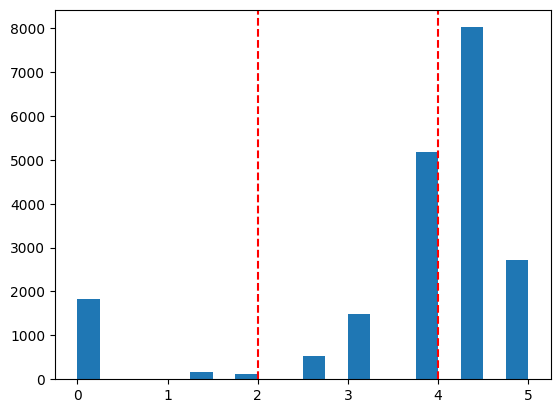

In [12]:
import matplotlib.pyplot as plt

plt.hist(y, bins=20)
plt.axvline(2, color='r', linestyle='--')  
plt.axvline(4, color='r', linestyle='--') 
plt.show()


## Let's start tuning the hyperparameters

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

#### Train-test-validation split 

In [14]:
class TrainValidationTest(BaseEstimator, TransformerMixin):
        def __init__(self, test_size=0.2, random_state=21, stratified=True):
            self.test_size = test_size
            self.random_state = random_state
            self.stratified = stratified
        def split(self, X , y):
            stratify = y if self.stratified else None
            X_train, X_test, y_train, y_test =train_test_split(
                X, y, test_size=self.test_size, random_state=self.random_state, stratify=stratify
            )
            stratify = y_train if self.stratified else None
            X_train, X_valid, y_train, y_valid =train_test_split(
                X_train, y_train, test_size=self.test_size/(1-self.test_size), random_state=self.random_state, stratify=stratify
            )
        

            return X_train, X_valid, X_test, y_train, y_valid, y_test

#### Model that predicts the most popular class.

In [15]:
class MostFrequentClassifier(BaseEstimator, ClassifierMixin):
    """model that predicts the most popular class."""
    
    def __init__(self):
        self.most_frequent_class_ = None
        self.classes_ = None
    
    def fit(self, X, y):
        self.most_frequent_class_ = stats.mode(y, keepdims=True)[0][0]
        self.classes_ = np.unique(y)
        return self
    
    def predict(self, X):
        if self.most_frequent_class_ is None:
            raise ValueError("Model is not fitted yet. Please call fit() first.")
        # Возвращаем массив из самого частого класса для всех строк X
        return np.full(shape=len(X), fill_value=self.most_frequent_class_)

#### Model selection class


In [16]:
from copy import deepcopy
from itertools import product
from sklearn.metrics import get_scorer
def manual_grid_search(X_train, y_train, X_valid, y_valid, model_estimator,param_grid, cv, scoring='accuracy_score',  n_jobs=-1, error_score=np.nan):
    res=[]
    estimator=deepcopy(model_estimator)
    total_combinations = np.prod([len(v) for v in param_grid.values()])
    # get scorer for valid score
    scorer = get_scorer(scoring)

    for params in tqdm(list(product(*param_grid.values())), total=total_combinations, desc="GridSearch"):

        current_model = deepcopy(estimator)
        current_model.set_params(**(dict(zip(param_grid.keys(), params))))
        try:
            score=cross_val_score(
                current_model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=n_jobs,error_score=error_score
            )

            current_model.fit(X_train, y_train)
            valid_score=scorer(current_model, X_valid, y_valid)

            res.append({
                'train_score': score.mean(),
                'valid_score': valid_score,
                'params': dict(zip(param_grid.keys(), params))
            })


        except Exception as e:
            print(f"Error with params {params}: {str(e)}")
            res.append({
                'params': dict(zip(param_grid.keys(), params)),
                'train_score': 'Na',
                'valid_score': 'Na'
            })
            continue
        
    return pd.DataFrame(res).sort_values('valid_score', ascending=False)
# I know I should have used a dict instead of model name, but I don't care.
class ModelSelection:
    def __init__ (self,estimators,estimators_name, grid_dict, scoring='accuracy_score'):
        self.estimators=estimators
        if isinstance(scoring, str):
            self.scoring = get_scorer(scoring)
        else:
            self.scoring = scoring
        self.estimators_name=estimators_name
        self.grid_dict=grid_dict
        self.results=pd.DataFrame()
        self.best_res=[]
    def choose(self,X_train, y_train, X_valid, y_valid, cv=2):
        """
        Method choose() takes X_train, y_train, X_valid, y_valid, optional cv, 
        and returns the name of the best model among all the models on the validation set
        """
        for estimator in self.estimators:
            model_name= self.estimators_name[self.estimators.index(estimator)]
            search_res=manual_grid_search(X_train,y_train,X_valid, y_valid,estimator,self.grid_dict[model_name], cv=cv, scoring=self.scoring)
            search_res['model']=model_name
            best_params = search_res.head(1)['params'].item()
            best_train_score = search_res.head(1)['train_score'].item()
            best_valid_score = search_res.head(1)['valid_score'].item()
            self.results=pd.concat([self.results, search_res], axis=0, ignore_index=True)
            self.best_res.append({
                'model': model_name,
                'params': best_params,
                'valid_score': best_valid_score,
                'train_score': best_train_score
            })
            
            print(f"Best params for model{model_name}: {best_params}")
            print(f"training score[{self.scoring}]: {best_train_score:.3f}")
            print(f"Best on validation set score[{self.scoring}]: {best_valid_score:.3f}")
        self.best_res=pd.DataFrame(self.best_res)
        self.best_res.sort_values('valid_score', ascending=False,inplace=True)
        best_model_name=self.best_res.head(1)['model'].item()
        print(f"\nBest model: {best_model_name}\nwith params: {self.best_res.head(1)['params'].item()}\nand score: {self.best_res.head(1)['valid_score'].item()}")
        return self.results.sort_values('valid_score', ascending=False)
    def fit_score(self,X_comb,y_comb, X_test, y_test):
        params=self.best_res.head(1)['params'].item()
        model_name=self.best_res.head(1)['model'].item()
        print(f'Taking model: {model_name} with params:{params}')
        best_estimator=self.estimators[self.estimators_name.index(model_name)]
        best_estimator.set_params(**(params))
        best_estimator.fit(X_comb,y_comb)
        scorer=get_scorer(self.scoring)
        print("the final score is :",(scorer(best_estimator,X_test,y_test)))        

In [17]:
def fit_score(estimator, params, X_comb, y_comb, X_test, y_test, scoring='accuracy'):
        estimator.set_params(**(params))
        estimator.fit(X_comb,y_comb)
        scorer=get_scorer(scoring)
        print("the final score is :",(scorer(estimator,X_test,y_test)))  

# Regression serch params

In [18]:
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


estimators = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    RandomForestRegressor(random_state=21, n_jobs=-1),
    GradientBoostingRegressor(random_state=21),
    XGBRegressor(random_state=21, n_jobs=-1)
]
manual_grid_search
estimators_name = [
    'LinearRegression',
    'Ridge',
    'Lasso',
    'ElasticNet',
    'RandomForest',
    'GradientBoosting',
    'XGBoost'
]

grid_dict = {
    'LinearRegression': {
        'fit_intercept': [True, False],
        'positive': [False]
    },
    'Ridge': {
        'alpha': [0.1, 1.0, 10.0],  
        'solver': ['svd', 'cholesky', 'saga']  
    },
    'Lasso': {
        'alpha': [0.01, 0.1, 1.0],  
        'selection': ['cyclic']
    },
    'ElasticNet': {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.3, 0.5, 0.7] 
    },
    'RandomForest': {
        'n_estimators': [50,100, 200], 
        'max_depth': [15,30, None],  
        'min_samples_split': [2, 5,10],
        'max_features': ['sqrt']
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

Regression grid search


In [19]:
scoring='neg_root_mean_squared_error'


splitter = TrainValidationTest(stratified=True)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitter.split(X, y)
search_parametrs= ModelSelection(estimators,estimators_name, grid_dict, scoring)
result_reg_serching=search_parametrs.choose(X_train, y_train, X_valid, y_valid)


GridSearch:   0%|          | 0/2 [00:00<?, ?it/s]

Best params for modelLinearRegression: {'fit_intercept': True, 'positive': False}
training score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.332
Best on validation set score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.294


GridSearch:   0%|          | 0/9 [00:00<?, ?it/s]

Best params for modelRidge: {'alpha': 10.0, 'solver': 'cholesky'}
training score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.308
Best on validation set score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.291


GridSearch:   0%|          | 0/3 [00:00<?, ?it/s]

Best params for modelLasso: {'alpha': 0.01, 'selection': 'cyclic'}
training score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.333
Best on validation set score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.332


GridSearch:   0%|          | 0/9 [00:00<?, ?it/s]

Best params for modelElasticNet: {'alpha': 0.01, 'l1_ratio': 0.3}
training score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.317
Best on validation set score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.312


GridSearch:   0%|          | 0/27 [00:00<?, ?it/s]

Best params for modelRandomForest: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'sqrt'}
training score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.307
Best on validation set score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.279


GridSearch:   0%|          | 0/16 [00:00<?, ?it/s]

Best params for modelGradientBoosting: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
training score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.312
Best on validation set score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.297


GridSearch:   0%|          | 0/32 [00:00<?, ?it/s]

Best params for modelXGBoost: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}
training score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.309
Best on validation set score[make_scorer(root_mean_squared_error, greater_is_better=False, response_method='predict')]: -1.295

Best model: RandomForest
with params: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'sqrt'}
and score: -1.2787395168222169


In [20]:
print("Calc score on the best model")

best_model_name = result_reg_serching.iloc[0]['model']
best_estimator = estimators[estimators_name.index(best_model_name)]
params= result_reg_serching.iloc[0]['params']
print(f'Taking model: {best_model_name} with params:{params}')
X_comb=pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_comb=pd.concat([y_train, y_valid], axis=0, ignore_index=True)

fit_score(best_estimator, params, X_comb,y_comb, X_test,y_test, scoring=scoring)

Calc score on the best model
Taking model: RandomForest with params:{'n_estimators': 200, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'sqrt'}
the final score is : -1.2813684788556967


let's analyze the results

In [21]:
result_reg_serching.head()

,train_score,valid_score,params,model
23,-1.306587,-1.278740,"{'n_estimators': 200, 'max_depth': None, 'min_...",RandomForest
24,-1.308152,-1.282075,"{'n_estimators': 100, 'max_depth': None, 'min_...",RandomForest
25,-1.311301,-1.283716,"{'n_estimators': 50, 'max_depth': None, 'min_s...",RandomForest
26,-1.320595,-1.285510,"{'n_estimators': 200, 'max_depth': None, 'min_...",RandomForest
27,-1.304220,-1.287606,"{'n_estimators': 200, 'max_depth': 30, 'min_sa...",RandomForest


Lets take  RandomForest with params:{'n_estimators': 200, 'max_depth': 30, 'min_samples_split': 2, 'max_features': 'sqrt'}
with the final score : -1.260777480024706

In [22]:
RandomForestRegressor_model=RandomForestRegressor(random_state=21, n_jobs=-1)
RandomForestRegressor_model.set_params(**(result_reg_serching.iloc[0]['params']))


RandomForestRegressor(max_features='sqrt', min_samples_split=10,
                      n_estimators=200, n_jobs=-1, random_state=21)

lets try do model that classifays on regression purpose 

In [23]:
def rating_to_сat(y):
    bins = [0, 2, 4, 6]
    labels = ['bad', 'so-so', 'great']
    return pd.cut(y, bins=bins, labels=labels).astype(str)
class RegressionToClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, regressor=None, bins=[0, 2, 4, 6], labels=['bad', 'so-so', 'great']):
        self.regressor = regressor if regressor is not None else RandomForestRegressor()
        self.bins = bins
        self.labels = labels
    
    def fit(self, X, y):
        self.regressor.fit(X, y)
        return self
    
    def predict(self, X):
        y_pred = self.regressor.predict(X)
        return pd.cut(y_pred, bins=self.bins, labels=self.labels, include_lowest=True)
    
    def predict_proba(self, X):
        raise NotImplementedError("predict_proba is not implemented for this classifier")
regresRegressionToClassifier = RegressionToClassifier(RandomForestRegressor_model)
regresRegressionToClassifier.fit(X_comb,y_comb)
y_test_classification=rating_to_сat(y_test)
y_pred=regresRegressionToClassifier.predict(X_test)
accuracy_score(y_test_classification,y_pred)


0.4525056095736724

very low accuracy, we cant take those model

# classification

## Data with clases ```0, 1, 2, 3, 4, 5```

#### prepare data to classification

In [24]:
def closest_int(y):
    return y.round().astype(int)

splitter = TrainValidationTest()
X_train, X_valid, X_test, y_train, y_valid, y_test = splitter.split(X, closest_int(y))
X_comb=pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_comb=np.concatenate([y_train, y_valid]) 
y_comb1=pd.DataFrame(y_comb)

In [25]:
def find_examples(X_comb, y_comb, target_class):
    # Преобразуем X_comb в DataFrame, если это numpy массив
    if isinstance(X_comb, np.ndarray):
        X_comb = pd.DataFrame(X_comb, columns=app.ingredient_features)  # Убедись, что ingredient_features доступны
    indices = np.where(y_comb == target_class)[0]
    if len(indices) == 0:
        print(f"No examples found for class {target_class}")
        return None
    # Берём первый пример
    example_idx = indices[0]
    # Извлекаем ингредиенты (где значение 1)
    ingredients = X_comb.iloc[example_idx][X_comb.iloc[example_idx] == 1].index.tolist()
    return ingredients, example_idx
for target_class in [0, 1]:
    result = find_examples(X_comb, y_comb, target_class)
    if result is not None:
        ingredients, idx = result
        print(f"\nClass {target_class} example (index {idx}):")
        print(f"Ingredients: {ingredients}")
        print(f"True class: {y_comb[idx]}")


Class 0 example (index 21):
Ingredients: ['bread']
True class: 0

Class 1 example (index 143):
Ingredients: ['cherry', 'lemon juice']
True class: 1


#### diffrent models variants

In [26]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from xgboost import XGBClassifier

estimators = [
    RandomForestClassifier(random_state=21, n_jobs=-1),
    GradientBoostingClassifier(random_state=21),
    BaggingClassifier(random_state=21, n_jobs=-1),
    XGBClassifier(random_state=21, n_jobs=-1)
]

estimators_name = [
    'RandomForest',
    'GradientBoosting',
    'Bagging',
    'XGBoost'
]

grid_dict = {
    'RandomForest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [20, 30, None],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2'],
        'class_weight': ['balanced', None]
    },
    'GradientBoosting': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5],
        'subsample': [0.8, 1.0]
    },
    'Bagging': {
        'n_estimators': [10, 50, 100],
        'max_samples': [0.5, 0.8, 1.0],
        'max_features': [0.5, 0.8, 1.0],
        'bootstrap': [True, False]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

#### Make metric 


I choose custom metric precision on classes 0, 1

In [27]:
from sklearn.metrics import make_scorer, precision_score, recall_score
def custom_f1(y_true, y_pred):
    p0 = precision_score(y_true == 0, y_pred == 0, zero_division=0)
    p1 = precision_score(y_true == 1, y_pred == 1, zero_division=0)
    r0 = recall_score(y_true == 0, y_pred == 0, zero_division=0)
    r1 = recall_score(y_true == 1, y_pred == 1, zero_division=0)
    # Средняя F1-метрика для классов 0 и 1
    f1_0 = 2 * (p0 * r0) / (p0 + r0) if (p0 + r0) > 0 else 0
    f1_1 = 2 * (p1 * r1) / (p1 + r1) if (p1 + r1) > 0 else 0
    return (f1_0 + f1_1) / 2

custom_scorer = make_scorer(custom_f1)


#### search best model

In [28]:
search_parametrs= ModelSelection(estimators,estimators_name, grid_dict, scoring=custom_scorer)
result_class_serching1=search_parametrs.choose(X_train, y_train, X_valid, y_valid)

GridSearch:   0%|          | 0/108 [00:00<?, ?it/s]

Best params for modelRandomForest: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'max_features': 'log2', 'class_weight': 'balanced'}
training score[make_scorer(custom_f1, response_method='predict')]: 0.217
Best on validation set score[make_scorer(custom_f1, response_method='predict')]: 0.220


GridSearch:   0%|          | 0/16 [00:00<?, ?it/s]

Best params for modelGradientBoosting: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}
training score[make_scorer(custom_f1, response_method='predict')]: 0.132
Best on validation set score[make_scorer(custom_f1, response_method='predict')]: 0.145


GridSearch:   0%|          | 0/54 [00:00<?, ?it/s]

/home/chumba/projects/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/chumba/projects/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/chumba/projects/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.w

Best params for modelBagging: {'n_estimators': 50, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap': False}
training score[make_scorer(custom_f1, response_method='predict')]: 0.189
Best on validation set score[make_scorer(custom_f1, response_method='predict')]: 0.225


GridSearch:   0%|          | 0/32 [00:00<?, ?it/s]

Best params for modelXGBoost: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 1.0}
training score[make_scorer(custom_f1, response_method='predict')]: 0.096
Best on validation set score[make_scorer(custom_f1, response_method='predict')]: 0.096

Best model: Bagging
with params: {'n_estimators': 50, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap': False}
and score: 0.2249397396753977


Let's look closely at the results.

In [29]:
result_class_serching1.head()

,train_score,valid_score,params,model
124,0.189157,0.224940,"{'n_estimators': 50, 'max_samples': 0.5, 'max_...",Bagging
125,0.193318,0.224216,"{'n_estimators': 10, 'max_samples': 0.5, 'max_...",Bagging
126,0.178492,0.220286,"{'n_estimators': 100, 'max_samples': 0.8, 'max...",Bagging
127,0.170768,0.220174,"{'n_estimators': 50, 'max_samples': 1.0, 'max_...",Bagging
0,0.217116,0.220149,"{'n_estimators': 200, 'max_depth': None, 'min_...",RandomForest


lets take a look on diffrent scoring

In [30]:
model_name=result_class_serching1.iloc[0]['model']
best_classifaer_int=estimators[estimators_name.index(model_name)]
scoring="accuracy"
params=result_class_serching1.iloc[0]['params']
print(f"calculate {scoring} for model {model_name} with params {params}")
fit_score(best_classifaer_int, params, X_comb,y_comb, X_test,y_test, scoring=scoring)


calculate accuracy for model Bagging with params {'n_estimators': 50, 'max_samples': 0.5, 'max_features': 1.0, 'bootstrap': False}
the final score is : 0.6364996260284218


In [31]:
def calc_scores(estimators, estimators_name, result_serching, scorings):
    results = []
    
    for row in result_serching.itertuples():
        estimator = estimators[estimators_name.index(row.model)]
        estimator.set_params(**(row.params))
        estimator.fit(X_comb, y_comb)
        model_results = {
            'model': row.model,
            'params': row.params
        }
        
        for scoring in scorings:
            if isinstance(scoring, str):
                scorer = get_scorer(scoring)
            else:
                scorer = scoring
            score = scorer(estimator, X_test, y_test)
            model_results[scoring] = score
        
        results.append(model_results)
    result_df = pd.DataFrame(results, columns=['model', 'params'] + scorings)
    return result_df


scorings = [
    'accuracy',
    custom_scorer,
    'precision_weighted',
    'recall_weighted',
    'f1_weighted',
    'balanced_accuracy',
]

In [32]:
calc_scores(estimators, estimators_name, result_class_serching1.head(8), scorings)


,model,params,accuracy,"make_scorer(custom_f1, response_method='predict')",precision_weighted,recall_weighted,f1_weighted,balanced_accuracy
0,Bagging,"{'n_estimators': 50, 'max_samples': 0.5, 'max_...",0.636500,0.242674,0.583668,0.636500,0.597830,0.283136
1,Bagging,"{'n_estimators': 10, 'max_samples': 0.5, 'max_...",0.612067,0.208987,0.563101,0.612067,0.580775,0.267167
2,Bagging,"{'n_estimators': 100, 'max_samples': 0.8, 'max...",0.651209,0.239255,0.590579,0.651209,0.599907,0.273796
3,Bagging,"{'n_estimators': 50, 'max_samples': 1.0, 'max_...",0.662428,0.200314,0.604310,0.662428,0.599854,0.259577
4,RandomForest,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.618050,0.251168,0.589426,0.618050,0.598951,0.315497
5,RandomForest,"{'n_estimators': 300, 'max_depth': None, 'min_...",0.601097,0.246429,0.587342,0.601097,0.591871,0.318662
6,RandomForest,"{'n_estimators': 100, 'max_depth': None, 'min_...",0.617302,0.251370,0.590871,0.617302,0.598832,0.317324
7,Bagging,"{'n_estimators': 100, 'max_samples': 1.0, 'max...",0.666667,0.209727,0.611007,0.666667,0.601805,0.261278


#### let's look at the naive classificator model


In [33]:
naive_est=[MostFrequentClassifier()]
naive_name=['MostFrequentClassifier']
naive_df=pd.DataFrame({
    'model': ['MostFrequentClassifier'],
    'params': [{}]
})
calc_scores(naive_est, naive_name, naive_df, scorings)


,model,params,accuracy,"make_scorer(custom_f1, response_method='predict')",precision_weighted,recall_weighted,f1_weighted,balanced_accuracy
0,MostFrequentClassifier,{},0.657691,0.0,0.432558,0.657691,0.52188,0.166667


## Data with 3 clases : ```0, 1, 2``` (bad, so-so, great)

binarize the target column by converting the integers to classes ‘bad’ (0, 1), ‘so-so’ (2, 3), ‘great’ (4, 5).

In [34]:
converted_classes_y=pd.cut(closest_int(y), bins = [-1, 1, 3, 5], labels = [0, 1, 2])

splitter = TrainValidationTest(stratified=True)
X_train, X_valid, X_test, y_train, y_valid, y_test = splitter.split(X, converted_classes_y)
X_comb=pd.concat([X_train, X_valid], axis=0, ignore_index=True)
y_comb=pd.concat([y_train, y_valid], axis=0, ignore_index=True)

choose the metric


In [35]:
from sklearn.metrics import make_scorer, precision_score, recall_score

def f1_for_class_zero(y_true, y_pred):
    # Точность для класса 0
    p0 = precision_score(y_true == 0, y_pred == 0, zero_division=0)
    # Полнота для класса 0
    r0 = recall_score(y_true == 0, y_pred == 0, zero_division=0)
    # F1-метрика для класса 0
    f1_0 = 2 * (p0 * r0) / (p0 + r0) if (p0 + r0) > 0 else 0
    return f1_0

f1_0_scorer = make_scorer(f1_for_class_zero)

In [36]:
search_parametrs= ModelSelection(estimators,estimators_name, grid_dict, scoring=f1_0_scorer)
result_class_serching2=search_parametrs.choose(X_train, y_train, X_valid, y_valid)

GridSearch:   0%|          | 0/108 [00:00<?, ?it/s]

Best params for modelRandomForest: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'log2', 'class_weight': 'balanced'}
training score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.349
Best on validation set score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.363


GridSearch:   0%|          | 0/16 [00:00<?, ?it/s]

Best params for modelGradientBoosting: {'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.8}
training score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.191
Best on validation set score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.164


GridSearch:   0%|          | 0/54 [00:00<?, ?it/s]

/home/chumba/projects/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/chumba/projects/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/chumba/projects/DS_Bootcamp.Team01.ID_886525-Team_TL_shirledo.396ad497_d1b1_4d29-1/src/venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.w

Best params for modelBagging: {'n_estimators': 100, 'max_samples': 0.8, 'max_features': 1.0, 'bootstrap': True}
training score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.257
Best on validation set score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.307


GridSearch:   0%|          | 0/32 [00:00<?, ?it/s]

Best params for modelXGBoost: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8}
training score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.155
Best on validation set score[make_scorer(f1_for_class_zero, response_method='predict')]: 0.117

Best model: RandomForest
with params: {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'log2', 'class_weight': 'balanced'}
and score: 0.36307053941908707


In [37]:
scorings = [
    'accuracy',
    f1_0_scorer,
    'precision_weighted',
    'recall_weighted',
    'f1_weighted',
    'balanced_accuracy',
]
model_name=result_class_serching2.iloc[0]['model']
best_classifaer=estimators[estimators_name.index(model_name)]
params=result_class_serching2.iloc[0]['params']
print(f"calculate {scoring} for model {model_name} with params {params}")
fit_score(best_classifaer, params, X_comb,y_comb, X_test,y_test, scoring=f1_0_scorer)
calc_scores(estimators, estimators_name, result_class_serching2.head(13), scorings)


calculate accuracy for model RandomForest with params {'n_estimators': 300, 'max_depth': None, 'min_samples_split': 10, 'max_features': 'log2', 'class_weight': 'balanced'}
the final score is : 0.3833671399594321


,model,params,accuracy,"make_scorer(f1_for_class_zero, response_method='predict')",precision_weighted,recall_weighted,f1_weighted,balanced_accuracy
0,RandomForest,"{'n_estimators': 300, 'max_depth': None, 'min_...",0.722264,0.383367,0.729871,0.722264,0.723961,0.498320
1,RandomForest,"{'n_estimators': 100, 'max_depth': None, 'min_...",0.723012,0.373360,0.731457,0.723012,0.725008,0.497737
2,RandomForest,"{'n_estimators': 100, 'max_depth': None, 'min_...",0.730740,0.374737,0.732273,0.730740,0.729676,0.495884
3,RandomForest,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.721267,0.386318,0.729332,0.721267,0.723040,0.498742
4,RandomForest,"{'n_estimators': 300, 'max_depth': None, 'min_...",0.731738,0.375134,0.730910,0.731738,0.729706,0.493445
5,RandomForest,"{'n_estimators': 100, 'max_depth': None, 'min_...",0.716779,0.363823,0.727711,0.716779,0.720613,0.493322
6,RandomForest,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.723261,0.372529,0.729923,0.723261,0.724984,0.495487
7,RandomForest,"{'n_estimators': 100, 'max_depth': None, 'min_...",0.706806,0.366700,0.724943,0.706806,0.713719,0.492272
8,RandomForest,"{'n_estimators': 300, 'max_depth': None, 'min_...",0.725256,0.376569,0.731485,0.725256,0.726826,0.498398
9,RandomForest,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.731738,0.372340,0.732173,0.731738,0.730250,0.494789


#### let's look at the naive classificator model


In [38]:
naive_est=[MostFrequentClassifier()]
naive_name=['MostFrequentClassifier']
naive_df=pd.DataFrame({
    'model': ['MostFrequentClassifier'],
    'params': [{}]
})
calc_scores(naive_est, naive_name, naive_df, scorings)


,model,params,accuracy,"make_scorer(f1_for_class_zero, response_method='predict')",precision_weighted,recall_weighted,f1_weighted,balanced_accuracy
0,MostFrequentClassifier,{},0.793318,0,0.629354,0.793318,0.701888,0.333333


# Decision

The best model based on a combination of several metrics is the bagging model with 6 classes : ```0, 1, 2, 3, 4, 5```

In [44]:
params=result_class_serching2.iloc[10]['params']
best_classifaer=RandomForestClassifier(random_state=21, n_jobs=-1)
best_classifaer.set_params(**params)
print(f"best model RandomForest with params {params}")
calc_scores(estimators, estimators_name, result_class_serching2.iloc[[10]], scorings)

best model RandomForest with params {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 2, 'max_features': 'log2', 'class_weight': 'balanced'}


,model,params,accuracy,"make_scorer(f1_for_class_zero, response_method='predict')",precision_weighted,recall_weighted,f1_weighted,balanced_accuracy
0,RandomForest,"{'n_estimators': 200, 'max_depth': None, 'min_...",0.746946,0.383747,0.734455,0.746946,0.738501,0.490814


let's save the best model

In [45]:
best_classifaer.fit(X_comb,y_comb)

import joblib
joblib.dump(best_classifaer,f"{data_path}best_classifier_model.joblib")

['data/best_classifier_model.joblib']

In [46]:
pd.DataFrame(best_classifaer.predict(X_comb)).value_counts()

0
2    11599
0     2493
1     1949
Name: count, dtype: int64

# Create csv for similiar recipes

In [24]:
from bs4 import BeautifulSoup
from urllib.parse import quote_plus
import time
import os
def load_or_create_dataframe(file_path, cols_for_similarity):
    """Loads DataFrame from file or creates new one if file doesn't exist.
    Adds missing columns if needed."""
    if os.path.exists(file_path):
        df = pd.read_csv(file_path, low_memory=False)
        missing_cols = set(cols_for_similarity + ['url']) - set(df.columns)
        if missing_cols:
            print(f"Warning: Missing columns in file: {missing_cols}")
            for col in missing_cols:
                if col in cols_for_similarity:
                    if col in df_similarity.columns:
                        df[col] = df_similarity[col]
                else:
                    df[col] = None
    else:
        df = pd.DataFrame(columns=cols_for_similarity + ['url'])
        print(f"Created new DataFrame, file not found: {file_path}")
    return df


def get_first_recipe_url_from_search(recipe_title, session):
    """Searches for recipe on Epicurious and returns first result URL."""
    if not recipe_title or pd.isna(recipe_title):
        return None

    search_query = quote_plus(str(recipe_title))
    search_url = SEARCH_URL_TEMPLATE.format(search_query)

    try:
        response = session.get(search_url, headers=HEADERS, timeout=20)
        response.raise_for_status()
        time.sleep(REQUEST_DELAY_SCRAPE)

        soup = BeautifulSoup(response.text, 'html.parser')
        first_link_tag = soup.select_one('a[href^="/recipes/food/views/"]')

        if first_link_tag and first_link_tag.has_attr('href'):
            return BASE_URL + first_link_tag['href'].split('?')[0]
        return None

    except requests.exceptions.Timeout:
        print(f"  -> Timeout searching for '{recipe_title[:50]}...'")
        time.sleep(REQUEST_DELAY_SCRAPE * 2)
        return None
    except requests.exceptions.RequestException as e:
        print(f"  -> Request error for '{recipe_title[:50]}...': {e}")
        time.sleep(REQUEST_DELAY_SCRAPE * 2)
        return None
    except Exception as e:
        print(f"  -> Error parsing '{recipe_title[:50]}...': {e}")
        return None

In [25]:
cols_for_similarity = ['title', 'rating'] + features 
df_similarity = df[cols_for_similarity].copy()

# Load existing URLs to avoid re-scraping
df_with_urls = load_or_create_dataframe(f"{data_path}recipes_for_similarity.csv", cols_for_similarity)

# Merge existing URLs with current data
if not df_with_urls.empty:
    url_map = df_with_urls.set_index('title')['url'].to_dict()
    df_similarity['url'] = df_similarity['title'].map(url_map)
else:
    df_similarity['url'] = None

# Find records needing URL scraping
indices_to_scrape = df_similarity[df_similarity['url'].isna()].index
print(f"Start collecting URL for {len(indices_to_scrape)} recipes out of {len(df_similarity)}")

# Scrape missing URLs
session = requests.Session()
for index in tqdm(indices_to_scrape, desc="Scraping URLs"):
    title = df_similarity.loc[index, 'title']
    df_similarity.loc[index, 'url'] = get_first_recipe_url_from_search(title, session)
session.close()

Start collecting URL for 19862 recipes out of 20052


Scraping URLs:   0%|          | 0/19862 [00:00<?, ?it/s]

  -> Request error for 'Pickled Red Onions ...': 502 Server Error: Bad Gateway for url: https://www.epicurious.com/search?q=Pickled+Red+Onions+
  -> Request error for 'Butterflied Turkey with Fennel, Sausage, and Ricot...': 502 Server Error: Bad Gateway for url: https://www.epicurious.com/search?q=Butterflied+Turkey+with+Fennel%2C+Sausage%2C+and+Ricotta+Stuffing+
  -> Request error for 'Herbed Fish Rolls in White Wine with Grapes ...': 502 Server Error: Bad Gateway for url: https://www.epicurious.com/search?q=Herbed+Fish+Rolls+in+White+Wine+with+Grapes+
  -> Request error for 'Stovetop Butterscotch Apples and Cranberries ...': 502 Server Error: Bad Gateway for url: https://www.epicurious.com/search?q=Stovetop+Butterscotch+Apples+and+Cranberries+
  -> Request error for 'Chicken Sates with Peanut Curry Sauce ...': 500 Server Error: Internal Server Error for url: https://www.epicurious.com/search?q=Chicken+Sates+with+Peanut+Curry+Sauce+
  -> Request error for 'Green Chile Stew ...': 500 S

In [26]:

df_similarity_with_url = df_similarity[['title', 'rating', 'url'] + features].copy()
found_urls_count = df_similarity_with_url['url'].notna().sum()
total_recipes = len(df_similarity_with_url)
print(f"Found {found_urls_count} URLs out of {total_recipes}")

print(f"Saving DataFrame for finding similarity by size: {df_similarity_with_url.shape}")
df_similarity_with_url.to_csv(f"{data_path}recipes_for_similarity.csv", index=False)

Found 19995 URLs out of 20052
Saving DataFrame for finding similarity by size: (20052, 325)


In [27]:
row = df_similarity_with_url.iloc[0]
row[row == 1].index.tolist()

['apple', 'bean', 'lentil', 'lettuce', 'tomato', 'turkey']

In [28]:
df_similarity_with_url.iloc[0]["rating"]

np.float64(2.5)